# Image Classification with PyTorch

## Data loading


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms

In [2]:
#Torchvision contains convinience functions for popular datasets like MNIST
ds_train = datasets.MNIST('data', train=True, download=True)

Each sample is a 28x28 image

(<PIL.Image.Image image mode=L size=28x28 at 0x105F0D820>, 5)


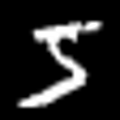

In [3]:
#If we index this dataset, we get a single data point: a PIL image and an Integer
print(ds_train[0])
ds_train[0][0].resize((120,120))

Before we pass samples from the dataset to our model, we would like to normalize the data and convert the samples to PyTorch tensors. We begin by computing the normalization constants, i.e. the mean and the standard deviation of the pixel values in the MNIST training dataset.

In [4]:
# lets get only the images 
ims_train = ds_train.data
ims_train = ims_train.float() / 255.

In [5]:
#########################################################################
# TODO: calculate the mean and std of MNIST images
# hint: to look for operations on pytorch tensor, refer to the official PyTorch docs 
# https://pytorch.org/docs/stable/
#########################################################################
mu = torch.mean(ims_train)
std = torch.std(ims_train)

We can now redefine the train and test datasets with the transform operations that perform normalization and conversion to tensors. 

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mu, std)
])
ds_train = datasets.MNIST('data', train=True, download=True, transform=transform)
ds_test = datasets.MNIST('data', train=False, download=True, transform=transform)

In [7]:
ds_train[0][0].min(), ds_train[0][0].max()

(tensor(-0.4241), tensor(2.8215))

Next, we will build a dataloader with a batch size of 64 and 4 workers (number of subprocesses that peform the dataloading). Important: you need to shuffle the training data, not the test data.

**NOTE**: if you encounter errors in data loading, try setting `NUM_WORKERS = 0` temporarily to get a more informative error message

In [8]:
BATCH_SIZE = 64
NUM_WORKERS = 4
#########################################################################
# TODO: Build a dataloader for both train and test data.
#########################################################################

# Train dataloader
dl_train = DataLoader(dataset=ds_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

# Test dataloader
dl_test = DataLoader(dataset=ds_train, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

## MLP in Pytorch

Next, we will build our customizable model class. We will replicate the model from our last exercises. However, now, we add another variable called `nLayer` that indicates how many hidden linear layers are in your network.

In [43]:
# These are the parameters to be used
nInput = 784 #The input dimension of the first linear layer
nOutput = 10 #The output dimension of the last linear layer
nLayer = 2 #The number of hidden layers
nHidden = 16 #The dimension of the intermediate outputs (output and input dimension of hidden layers)
act_fn = nn.ReLU() #Activation function

In [24]:
#########################################################################
# TODO: Implement the __init__ of the MLP class. 
# insert the activation after every linear layer. Important: the number of 
# hidden layers should be variable!
#########################################################################

class MLP(nn.Module):
    def __init__(self, nInput, nOutput, nLayer, nHidden, act_fn):
        super(MLP, self).__init__()
        layers = [] 
        
        ##### implement this part #####
        # Input layer -> Hidden layer
        layers.append(nn.Linear(nInput, nHidden))
        layers.append(act_fn)

        # Hidden layers -> Hidden layers
        for _ in range(nLayer-1):
            layers.append(nn.Linear(nHidden, nHidden))
            layers.append(act_fn)
        
        # Hidden layers -> Output layer
        layers.append(nn.Linear(nHidden, nOutput))

        ###############################
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = torch.flatten(x, 1)
        return self.model(x)

In [44]:
# Let's test if the forward pass works
# this should print torch.Size([1, 10])
t = torch.randn(1,1,28,28)
mlp = MLP(nInput, nOutput, nLayer, nHidden, act_fn)
mlp(t).shape

torch.Size([1, 10])

In [26]:
mlp

MLP(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=10, bias=True)
  )
)

We already implemented the test function for you

In [27]:
def test(model, dl_test, device='cpu'):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in dl_test:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(dl_test.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        test_loss, correct, len(dl_test.dataset),
        100. * correct / len(dl_test.dataset)))

Now you only need to implement the training and you are good to go

In [28]:
#########################################################################
# TODO: Implement the missing part of the training function. As a loss function, we want to use cross entropy
# It can be called with F.cross_entropy().
# Hint: Pass through the model -> Backpropagate gradients -> Take gradient step
#########################################################################

def train(model, dl_train, optimizer, epoch, log_interval=100, device='cpu'):
    model.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(dl_train):
        data, target = data.to(device), target.to(device)
        
        # first we need to zero the gradient, otherwise PyTorch would accumulate them
        optimizer.zero_grad()         
        
        ##### implement this part #####
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        ###############################

        # stats
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(dl_train.dataset),
                100. * batch_idx / len(dl_train), loss.item()))

    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
        loss.item(), correct, len(dl_train.dataset), # changed loss to loss.item(), since loss is tensor
        100. * correct / len(dl_train.dataset)))

Ok, the setup is almost done. The only missing part is the optimizer. We are going to use Adam.

In [45]:
# reinitialize the mlp, so we can play with parameters right here
mlp = MLP(nInput, nOutput, nLayer, nHidden, act_fn)
optimizer = optim.Adam(mlp.parameters())

In [46]:
epochs = 10
for epoch in range(1, epochs + 1):
    train(mlp, dl_train, optimizer, epoch, log_interval=100)
    test(mlp, dl_test)

print ('Training is finished.')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.330253
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.530279
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.550367
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.423591
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.454173
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.233354
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.221317
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.204452
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.462727
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.153360

Train set: Average loss: 0.4058, Accuracy: 51104/60000 (85.2%)


Test set: Average loss: 0.2892, Accuracy: 54940/60000 (91.567%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.181808
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.198142
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.102287
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.292445
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.209039
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.202344
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.176936
Train Epoch: 2 [44800/60000 (75

After training, you should see test accuracies of > **94%** - Can you do some parameter tuning (e.g. increasing the number of layers or hidden dimension) to boost the test accuracy to > **97%**?

In [47]:
#########################################################################
#TODO: modify the parameters below to see which setting that you can get to 97%
#########################################################################
nLayer = 2 # change +1 did not imrpove by a lot... not worth it here
nHidden = 32 # *2 +1 did improve!
act_fn = nn.ReLU()

# reinitialize the mlp, so we can play with parameters right here
mlp = MLP(nInput, nOutput, nLayer, nHidden, act_fn)
optimizer = optim.Adam(mlp.parameters())

epochs = 10
for epoch in range(1, epochs + 1):
    train(mlp, dl_train, optimizer, epoch, log_interval=100)
    test(mlp, dl_test)

print ('Training is finished.')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.275732
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.839967
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.218795
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.212569
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.346788
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.092915
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.188334
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.296922
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.405609
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.242276

Train set: Average loss: 0.2570, Accuracy: 53664/60000 (89.4%)


Test set: Average loss: 0.1981, Accuracy: 56476/60000 (94.127%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.173846
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.309749
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.128486
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.072014
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.232209
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.130336
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.127055
Train Epoch: 2 [44800/60000 (75

Before you move on to the next exercise, you can further play with the other parameters (learning rate, epochs, a different optimizer, etc.) to get a feeling what can improve or hamper performance. 

## CNN
Alright, we matched our prior performance. Let's surpass it! You will soon see the power of CNN by building a small one yourself. The structure should be as follows



<table>
  <tr><th>CNN Architecture</th></tr>
  <tr><td>Conv2d: <code>C<sub>in</sub>=1</code>, <code>C<sub>out</sub>=32</code>, <code>K=3</code>, <code>S=1</code>, <code>P=0</code></td></tr>
  <tr><td>ReLU</td></tr>
  <tr><td>Conv2d: <code>C<sub>in</sub>=32</code>, <code>C<sub>out</sub>=64</code>, <code>K=3</code>, <code>S=1</code>, <code>P=0</code></td></tr>
  <tr><td>ReLU</td></tr>
  <tr><td>MaxPool2d: <code>K=2</code>, <code>S=2</code>, <code>P=0</code></td></tr>
  <tr><td>Dropout: <code>p=0.25</code></td></tr>
  <tr><td>Linear: <code>C<sub>in</sub>=9216</code>, <code>C<sub>out</sub>=128</code></td></tr>
  <tr><td>ReLU</td></tr>
  <tr><td>Dropout: <code>p=0.5</code></td></tr>
  <tr><td>Linear: <code>C<sub>in</sub>=128</code>, <code>C<sub>out</sub>=10</code></td></tr>
</table>

The layers you will need are: 

`nn.Conv2d,  nn.Linear,  nn.Dropout, nn.MaxPool2d, nn.Flatten`

See https://docs.pytorch.org/docs/stable/nn.html for a full description of different layers. For layers without parameters you can alternatively use these functions in the forward pass:  

`F.max_pool2d, torch.flatten`

The effect is the same - the layers  `nn.MaxPool2d` and `nn.Flatten` are simple wrappers around those functions.

In [48]:
#########################################################################
# TODO: Implement the __init__ and forward method of the CNN class. 
# Hint: do not forget to flatten the appropriate dimensions after the convolutional blocks. 
# A linear layers expects input of the shape (N, F) with batch size N and feature size F 
# whereas convolutional layers produce outputs of shape (N, C, H, W) with batch size N, 
# number of output channels C, output height H and output width W.
#########################################################################

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.drop1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(9216, 128)
        self.drop2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)


    def forward(self, x):
        x = F.relu(self.conv1(x))

        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.drop1(x)

        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = self.drop2(x)

        x = self.fc2(x)
        return x


In [49]:
# Let's test if the forward pass works
# this should print torch.Size([1, 10])
t = torch.randn(1,1,28,28)
cnn = CNN()
cnn(t).shape

torch.Size([1, 10])

Alright, let's train!

In [50]:
optimizer = optim.Adam(cnn.parameters())

In [51]:
epochs = 5
for epoch in range(1, epochs + 1):
    train(cnn, dl_train, optimizer, epoch, log_interval=100)
    test(cnn, dl_test)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.293362
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.264801
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.158314
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.187809
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.066994
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.202992
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.114826
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.270030
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.097608
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.070724

Train set: Average loss: 0.0508, Accuracy: 56430/60000 (94.0%)


Test set: Average loss: 0.0422, Accuracy: 59216/60000 (98.693%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.060346
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.058021
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.070655
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.125169
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.116533
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.072721
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.030192
Train Epoch: 2 [44800/60000 (75

This will probably take a bit longer to train, as a convolutional network is not very efficient on a CPU. The current settings should get you around **99%** accuracy. Nice! 
Again, you should try different hyperparameters and see how far you can push the performance.

### Inline Question

If your model weight is randomly initalized, and no training is done as above. What accuracy do you think the model will get for a 10-class classification task in theory?

**Your answer**: When the weights are random initalized and we don't train, the predictions are also random over the classes. So the expected accuracy is 1/10 (10%).


## Training on CIFAR10

Now we are going to move to something more challenging - CIFAR10. We can reuse most of the code above. Thankfully, CIFAR is also a popular dataset, so we can again make use of a PyTorch convience function.

In [52]:
ds_train = datasets.CIFAR10(root='./data', train=True, download=True)

As in the previous exercise, the dataset is not normalized yet, so we need to calculate the normalization constants.

In [53]:
ims_train = torch.tensor(ds_train.data)
ims_train = ims_train.float() / 255.

In [54]:
ims_train.std((0,1,2))

tensor([0.2470, 0.2435, 0.2616])

In [55]:
#########################################################################
# TODO: calculate the mean and std of CIFAR
# hint: We want the mean and std of the channel dimension, these should
# be 3 dimensional
#########################################################################
mu = torch.mean(ims_train, dim=(0, 1, 2))
std = torch.std(ims_train, dim=(0, 1, 2))


In [56]:
torch.mean(ims_train, dim=(0,1,2))

tensor([0.4914, 0.4822, 0.4465])

For CIFAR we want to additionally apply some data augmentation transforms to the samples in our dataset for improved generalization. You can find a comprehensive overview of available transforms under the following link.

https://docs.pytorch.org/vision/0.8/transforms.html

In [58]:
BATCH_SIZE = 128
NUM_WORKERS = 0 # if you encounter some unexpected errors in data loading, try setting `NUM_WORKERS = 0`
#########################################################################
# TODO: Implement the proper transforms for the training and test dataloaders. 
# Then build train and test dataloaders with batch size 128 and 4 workers
#
# These are the transforms that should be applied.
# Train: 
# - Apply a random crop with size 32 on a padded version of the image with P=4
# - Flip the image horizontally with a probability of 40 %
# - Transform to a Tensor
# - Normalize with the constants calculated above
# Test: 
# - Transform to a Tensor
# - Normalize with the constants calculated above
#########################################################################

# Transform train
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.ToTensor(),
    transforms.Normalize(mu, std)
])

# Transform test
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mu, std)
])

ds_train = datasets.CIFAR10('./data', train=True, download=True, transform=transform_train)
ds_test = datasets.CIFAR10('./data', train=False, download=True, transform=transform_test)

dl_train = DataLoader(dataset=ds_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
dl_test = DataLoader(dataset=ds_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

Setting up the  optimizer, this time we use stochastic gradient descent (SGD). The scheduler adapts the learning rate during training.

In [59]:
cnn = CNN()
optimizer = optim.SGD(cnn.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [60]:
epochs = 5
for epoch in range(1, epochs + 1):
    train(cnn, dl_train, optimizer, epoch, log_interval=100)
    test(cnn, dl_test)    
    scheduler.step()

RuntimeError: Given groups=1, weight of size [32, 1, 3, 3], expected input[128, 3, 32, 32] to have 1 channels, but got 3 channels instead

This will not work. You should see the following error message

```
Given groups=1, weight of size [32, 1, 3, 3], expected input[128, 3, 32, 32] to have 1 channels, but got 3 channels instead
```

This error is telling us that something is not right in the definition of our model. Copy the CNN class from above and make changes, so the training works.

In [62]:
#########################################################################
# TODO: Adapt the definition from the CNN class above to work on CIFAR.
# You can copy and run the following prompt for evaluation:
# CNN()(torch.randn(1,3,32,32)).shape
# It should print 'torch.Size([1, 10])'
# Hint: You need to change 2 things. 
#########################################################################

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=0) # changed input channels from 1 to 3
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.drop1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(12544, 128) # changed input features from 9216 to 12544 (64*14*14)
        self.drop2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)


    def forward(self, x):
        x = F.relu(self.conv1(x))

        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.drop1(x)

        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = self.drop2(x)

        x = self.fc2(x)
        return x


Let's try again

In [63]:
cnn = CNN()
optimizer = optim.SGD(cnn.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

epochs = 10
for epoch in range(1, epochs + 1):
    train(cnn, dl_train, optimizer, epoch, log_interval=100)
    test(cnn, dl_test)    
    scheduler.step()

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.301766
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.931155
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.956576
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.771405

Train set: Average loss: 1.8265, Accuracy: 12827/50000 (25.7%)


Test set: Average loss: 1.7363, Accuracy: 3473/10000 (34.730%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.869968
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.999291
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.860697
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.757842

Train set: Average loss: 1.5484, Accuracy: 16441/50000 (32.9%)


Test set: Average loss: 1.5674, Accuracy: 4073/10000 (40.730%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.877389
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.742516
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.680810
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.734778

Train set: Average loss: 1.7301, Accuracy: 18301/50000 (36.6%)


Test set: Average loss: 1.5093, Accuracy: 4566/10000 (45.660%)

Train Epoch: 4 [0/50000 (

This should give 40 - 50 % - and if you are not already on Colab it might cause your laptop to stress out a bit. The performance is a lot better than random, but we can definitely do better.

### Have fun with GPUs (Bonus Exercises)
The rest of the exercise is not graded but you can have some fun exploring the capability of these models further. :)



If you didn't already, move to Google Colab. To use a GPU, follow on the collaboratory menu tabs, "Runtime" => "Change runtime type" and set it to GPU. Then run the same training loop but now on GPU. To do so, we need to explicitly move our tensors to a GPU device - Note that our training loop as define above takes a device parameter as input and alreadt does the job for us.

It's as easy as:

In [ ]:
device = 'cuda'
if device == 'cuda': torch.backends.cudnn.benchmark = True # additional speed up

cnn = CNN()
optimizer = optim.SGD(cnn.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
cnn = cnn.to(device)

epochs = 10
for epoch in range(1, epochs + 1):
    train(cnn, dl_train, optimizer, epoch, log_interval=100, device=device)
    test(cnn, dl_test, device=device)    
    scheduler.step()

This should be way faster now. But the true advantage of the GPU is that we can use much bigger models now and still train them in a reasonable amount of time. PyTorch is again very handy. The torchvision library comes with varies state-of-the-art model architectures, some of which you have seen in the lecture.

In [ ]:
from torchvision.models import resnet18

In [ ]:
cnn = resnet18()
print(cnn)

Looks scary! But the only thing you need to change to make it work on CIFAR is the last layer.
Currently the last layer is:
```
  (fc): Linear(in_features=512, out_features=1000, bias=True)
```
out_features is the number of classes. This models are developed for Imagenet, a dataset with 1000 classes. So this part of the model you need to adapt. Additionally, you need to add a log-softmax layer again, as we us negative log-likelihood as the training criterion. 

In [ ]:
#########################################################################
# TODO: Adapt Resnet to work on CIFAR
#########################################################################


In [ ]:
# This should print 'torch.Size([16, 10])'
cnn(torch.randn(16,3,32,32)).shape

In [ ]:
device = 'cuda'
if device == 'cuda': torch.backends.cudnn.benchmark = True # this gives us additional speed up

optimizer = optim.SGD(cnn.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
cnn = cnn.to(device)

epochs = 50
for epoch in range(1, epochs + 1):
    train(cnn, dl_train, optimizer, epoch, log_interval=100, device=device)
    test(cnn, dl_test, device=device)    
    scheduler.step()

This should get us well above 75%, the best we got was ~ 80%.

If you would like to explore further, you can now use different torchvision architectures, optimizers (Adam is always a good choice), data augmentation techniques, and hyperparameter search to achieve a test accuracy of >90 %